In [2]:
import os
import sys
sys.path.insert(0, os.getcwd())
os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt
from numerics.utilities.misc import *
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel
import multiprocessing as mp
from tqdm import tqdm
import pickle

In [60]:

gamma, omega, n, eta, kappa = [1e1, 1e3, 10., 1., 1e2]#[1e1, 1e3, 1., 1., 1e4]
params = [gamma, omega, n, eta, kappa]
N_periods = 100.
single_period=2*np.pi/omega
total_time = N_periods*single_period
dt = single_period/50.
times = np.arange(0,total_time+dt,dt)
exp_path = str(params)+"/"

timms = np.linspace(100, len(times)-1,10).astype("int")

trajs = np.array(list(range(0,int(1e3))))


In [61]:
ers = []
fi = []
for itraj in tqdm(trajs):
    try:
        states_th = load_data(exp_path=exp_path,total_time=total_time, dt=dt,what="states_th.npy",itraj=itraj)
        fi.append(np.abs(states_th[:,0])**2)
    except Exception:
        ers.append(itraj)
fi = np.stack(fi)

means_der_th_sq = np.mean(fi,axis=0)
fisher = np.cumsum(means_der_th_sq,axis=0)*4*kappa*dt


100%|██████████| 1000/1000 [00:02<00:00, 368.21it/s]


In [83]:
itraj = 10
train_id=3
save_dir = misc_ML.get_training_save_dir(exp_path, total_time, dt, itraj,train_id)
loss = np.load(save_dir+"loss.npy")
params = np.load(save_dir+"params.npy")

In [104]:
import numerics.ML.misc as misc_ML
import numerics.ML.model as model_ML

timms = np.linspace(100, len(times)-1,10).astype("int")
ml_params = {}
erro = []
for itraj in tqdm(trajs):
    ml_params[itraj] = []
    try:
        for train_id,tt in enumerate(timms):
            save_dir = misc_ML.get_training_save_dir(exp_path, total_time, dt, itraj,train_id)
            loss = np.load(save_dir+"loss.npy")
            params = np.load(save_dir+"params.npy")
            ml_params[itraj].append(params[np.argmin(loss)])#
    except Exception:
        erro.append(itraj)
        pass

ml_params_ok = []
for v in ml_params.values():
    if len(v)==10:
        ml_params_ok.append(v)


100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s] 


In [114]:
lll =np.nanstd(np.stack(ml_params_ok),axis=0)

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


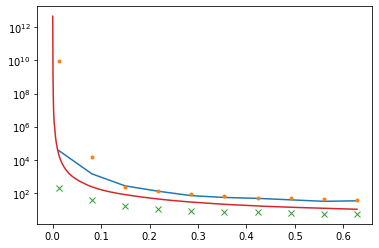

In [115]:
ax=plt.subplot()
ax.plot([times[k] for k in timms],np.nanmean((np.stack(ml_params_ok) -omega)**2, axis=0  ))
ax.plot([times[k] for k in timms],lor,'.')#np.nanmean((np.stack(ml_params_ok) -omega)**2, axis=0  ))
ax.plot([times[k] for k in timms],lll,'x')#np.nanmean((np.stack(ml_params_ok) -omega)**2, axis=0  ))
ax.plot(times,1/fisher)
ax.set_yscale("log")

In [111]:
lor = np.load("analysis/lorentzian_dev.npy")